- https://pytorch.org/vision/stable/models.html
- https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang

In [7]:
!nvidia-smi

Thu Apr  8 01:37:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# params

In [8]:
HOME = "/data/git/shopee-product-matching"
p_prp = f'{HOME}/output/prep002'
pdata = f'{HOME}/input/shopee-product-matching'

IMGSZ = 224
NWKRS = 8
BS = 32

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
PIN_MEMORY = True if DEVICE == torch.device("cuda") else False

# code

In [9]:
import matplotlib.pyplot as plt

## utils

In [10]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


## vision

In [34]:
import pandas as pd
import torchvision
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm import tqdm


class VDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.filepath[idx]
        img = Image.open(img_path)
        img = self.transforms(img)
        return img
    
# https://github.com/lukemelas/EfficientNet-PyTorch
tfms = transforms.Compose(
    [
        transforms.Resize((IMGSZ, IMGSZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


def mk_dl(df):
    ds = VDataset(df, tfms)
    dl = DataLoader(
        dataset=ds,
        batch_size=BS,
        num_workers=NWKRS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )
    return dl

# https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def mk_embedder(mdl):
    if isinstance(mdl, torchvision.models.resnet.ResNet):
        mdl.fc = Identity()
    if isinstance(mdl, EfficientNet):
        def extract_feats(input_):
            return mdl.extract_features(input_).mean(dim=(-1, -2))
        mdl.forward = extract_feats
    return mdl


def mk_feats(dl, mdl):
    device = torch.device(DEVICE)
    mdl = mdl.to(device)
    mdl.eval()
    lst = []
    for dat in tqdm(dl, total=len(dl)):
        with torch.no_grad():
            fts = mdl(dat.to(device))
        lst.append(fts.cpu().detach().numpy())
    feats = np.concatenate(lst)
    return feats

## neighbor

In [56]:
from cuml.neighbors import NearestNeighbors
import numpy as np

N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = dists_
        idx[a:b] = idx_
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

# run

In [36]:
df = pd.read_csv(f'{p_prp}/df_valid.csv')
pids = df.posting_id.values
targets = get_targets(df)

dl = mk_dl(df)

In [78]:
nm2mdl = {
    'resnet18': torchvision.models.resnet18(pretrained=True),
    'resnet34': torchvision.models.resnet34(pretrained=True),
    'resnet50': torchvision.models.resnet50(pretrained=True),
    'resnet101': torchvision.models.resnet101(pretrained=True),
    'resnet152': torchvision.models.resnet152(pretrained=True),
    "efficientnet-b0": EfficientNet.from_pretrained("efficientnet-b0"),
    "efficientnet-b1": EfficientNet.from_pretrained("efficientnet-b1"),
    "efficientnet-b2": EfficientNet.from_pretrained("efficientnet-b2"),
    "efficientnet-b3": EfficientNet.from_pretrained("efficientnet-b3"),
    "efficientnet-b4": EfficientNet.from_pretrained("efficientnet-b4"),
    "efficientnet-b5": EfficientNet.from_pretrained("efficientnet-b5"),
    "efficientnet-b6": EfficientNet.from_pretrained("efficientnet-b6"),
    "efficientnet-b7": EfficientNet.from_pretrained("efficientnet-b7"),
}

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b6
Loaded pretrained weights for efficientnet-b7


In [79]:
for dat in dl:
    dat 
    break

for nm,mdl in nm2mdl.items():
    mdl = mk_embedder(mdl)
    output = mdl(dat)
    print(nm, output.shape[1])

resnet18 512
resnet34 512
resnet50 2048
resnet101 2048
resnet152 2048
efficientnet-b0 1280
efficientnet-b1 1280
efficientnet-b2 1408
efficientnet-b3 1536
efficientnet-b4 1792
efficientnet-b5 2048
efficientnet-b6 2304
efficientnet-b7 2560


In [80]:
nm2feats = {nm: mk_feats(dl, mdl) for nm,mdl in nm2mdl.items()}

100%|██████████| 161/161 [00:51<00:00,  3.15it/s]


In [81]:
nm2nbrs = {nm: get_nbrs(feats) for nm,feats in nm2feats.items()}

100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


100%|██████████| 21/21 [00:05<00:00,  3.88it/s]

resnet18 resnet18, 0.679, 0.15000000000000002 


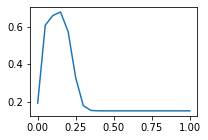

100%|██████████| 21/21 [00:05<00:00,  3.87it/s]

resnet34 resnet34, 0.675, 0.15000000000000002 


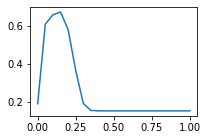

100%|██████████| 21/21 [00:05<00:00,  3.67it/s]

resnet50 resnet50, 0.674, 0.1 


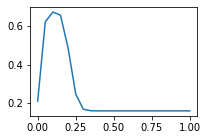

100%|██████████| 21/21 [00:05<00:00,  3.72it/s]

resnet101 resnet101, 0.678, 0.1 


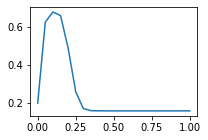

100%|██████████| 21/21 [00:05<00:00,  3.85it/s]


resnet152 resnet152, 0.678, 0.1 


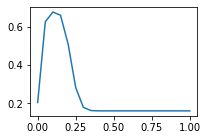

100%|██████████| 21/21 [00:04<00:00,  4.38it/s]

efficientnet-b0 efficientnet-b0, 0.696, 0.25 


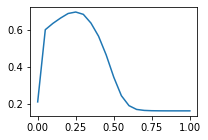

100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

efficientnet-b1 efficientnet-b1, 0.685, 0.25 


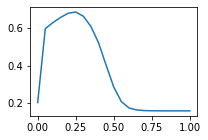

100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

efficientnet-b2 efficientnet-b2, 0.697, 0.30000000000000004 


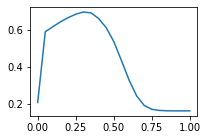

100%|██████████| 21/21 [00:04<00:00,  4.62it/s]

efficientnet-b3 efficientnet-b3, 0.696, 0.35000000000000003 


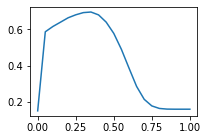

100%|██████████| 21/21 [00:04<00:00,  4.55it/s]

efficientnet-b4 efficientnet-b4, 0.676, 0.25 


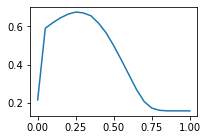

100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

efficientnet-b5 efficientnet-b5, 0.672, 0.30000000000000004 


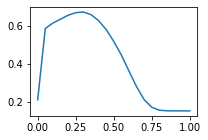

100%|██████████| 21/21 [00:04<00:00,  4.55it/s]

efficientnet-b6 efficientnet-b6, 0.669, 0.25 


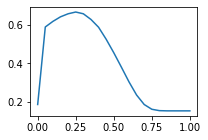

100%|██████████| 21/21 [00:04<00:00,  4.52it/s]

efficientnet-b7 efficientnet-b7, 0.667, 0.25 


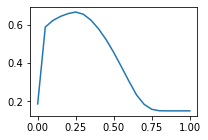

In [88]:
nm2res = {}
for nm, (dists, idx) in nm2nbrs.items():
    nm, (dists, idx)
    res = find_best(dists, idx)
    nm2res[nm] = res
    print(nm, f"{nm}, {res['f1_best']:.3f}, {res['thrsh_best']} ")
    plt.figure(figsize=(3,2))
    plt.plot(res['thrshes'], res['f1_lst'])  
    plt.show()


In [91]:
nm2f1 = {nm:res['f1_best'] for nm, res in nm2res.items()}

pd.DataFrame(nm2f1.items())

,0,1
0,resnet18,0.678927
1,resnet34,0.675146
2,resnet50,0.674423
3,resnet101,0.678389
4,resnet152,0.678062
5,efficientnet-b0,0.696100
6,efficientnet-b1,0.685225
7,efficientnet-b2,0.697450
8,efficientnet-b3,0.695914
9,efficientnet-b4,0.675585


# fin

In [69]:
!nvidia-smi

Thu Apr  8 02:00:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |   3516MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  